In [2]:
!pip3 install torch torchvision scikit-learn pandas matplotlib kaggle imbalanced-learn

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try brew install
    xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a Python library that isn't in Homebrew,
    use a virtual environment:
    
    python3 -m venv path/to/venv
    source path/to/venv/bin/activate
    python3 -m pip install xyz
    
    If you wish to install a Python application that isn't in Homebrew,
    it may be easiest to use 'pipx install xyz', which will manage a
    virtual environment for you. You can install pipx with
    
    brew install pipx
    
    You may restore the old behavior of pip by passing
    the '--break-system-packages' flag to pip, or by adding
    'break-system-packages = true' to your pip.conf file. The latter
    will permanently disable this error.
    
    If you disable this error, we STRONGLY recommend that you additionally
    pass the '--user' flag to pip, or set 

In [2]:
import sys
!{sys.executable} -m pip install imbalanced-learn



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Đọc dữ liệu từ file CSV
data = pd.read_csv('creditcard.csv')

# Chuẩn hóa cột 'Amount' và 'Time'
scaler = StandardScaler()
data['Amount_scaled'] = scaler.fit_transform(data[['Amount']])
data['Time_scaled'] = scaler.fit_transform(data[['Time']])

# Xóa các cột 'Class', 'Amount', và 'Time' chưa chuẩn hóa
X = data.drop(columns=['Class', 'Amount', 'Time'])
X['Amount'] = data['Amount_scaled']
X['Time'] = data['Time_scaled']

# Nhãn dữ liệu
y = data['Class']

In [4]:
# Chọn 10,000 dòng dữ liệu bình thường cho tập huấn luyện
train_data_normal = data[data['Class'] == 0].sample(n=10000)

# Chọn 200 dòng dữ liệu bình thường và 200 dòng dữ liệu bất thường cho tập kiểm tra
test_data_normal = data[data['Class'] == 0].sample(n=800)
test_data_fraud = data[data['Class'] == 1].sample(n=200)

# Kết hợp dữ liệu test (200 dòng bình thường + 200 dòng bất thường)
test_data = pd.concat([test_data_normal, test_data_fraud])

# Tạo các tập X_train và X_test
X_train = train_data_normal.drop(columns=['Class', 'Amount', 'Time'])
X_train['Amount'] = train_data_normal['Amount_scaled']
X_train['Time'] = train_data_normal['Time_scaled']

X_test = test_data.drop(columns=['Class', 'Amount', 'Time'])
X_test['Amount'] = test_data['Amount_scaled']
X_test['Time'] = test_data['Time_scaled']

# Nhãn dữ liệu kiểm tra (class 0 và 1)
y_test = test_data['Class']

In [5]:
# Chuyển đổi dữ liệu huấn luyện và kiểm tra sang tensor cho PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

In [6]:
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2_mu = nn.Linear(32, latent_dim)
        self.fc2_logvar = nn.Linear(32, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 32)
        self.fc4 = nn.Linear(32, input_dim)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Khởi tạo mô hình VAE
input_dim = X_train.shape[1]
latent_dim = 2
model = VAE(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện mô hình
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

epochs = 20
model.train()
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=32, shuffle=True)

for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 1, Loss: 35.91996705932617
Epoch 2, Loss: 33.41942370910645
Epoch 3, Loss: 32.85751545410156
Epoch 4, Loss: 32.66604925537109
Epoch 5, Loss: 32.60241415100098
Epoch 6, Loss: 32.514952105712894
Epoch 7, Loss: 32.33957395629883
Epoch 8, Loss: 32.2242927734375
Epoch 9, Loss: 32.17601220092774
Epoch 10, Loss: 32.12355321044922
Epoch 11, Loss: 32.04632970581055
Epoch 12, Loss: 32.01251160888672
Epoch 13, Loss: 31.979583016967773
Epoch 14, Loss: 31.954938165283203
Epoch 15, Loss: 31.961235195922853
Epoch 16, Loss: 31.924145727539063
Epoch 17, Loss: 31.938479791259766
Epoch 18, Loss: 31.89855184020996
Epoch 19, Loss: 31.90924674682617
Epoch 20, Loss: 31.88175142211914


In [7]:
# Đặt mô hình vào chế độ đánh giá
model.eval()
with torch.no_grad():
    X_test_pred, _, _ = model(X_test_tensor)
    reconstruction_loss = torch.mean((X_test_tensor - X_test_pred) ** 2, dim=1).numpy()

# Thiết lập ngưỡng phát hiện bất thường
threshold = np.percentile(reconstruction_loss,82)  # Ngưỡng 80%

# Dự đoán nhãn dựa trên ngưỡng
y_pred = (reconstruction_loss > threshold).astype(int)  # 1 là bất thường, 0 là bình thường

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# So sánh kết quả với nhãn thực tế
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Confusion Matrix:
 [[780  20]
 [ 40 160]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       800
           1       0.89      0.80      0.84       200

    accuracy                           0.94      1000
   macro avg       0.92      0.89      0.90      1000
weighted avg       0.94      0.94      0.94      1000

ROC AUC Score: 0.8875


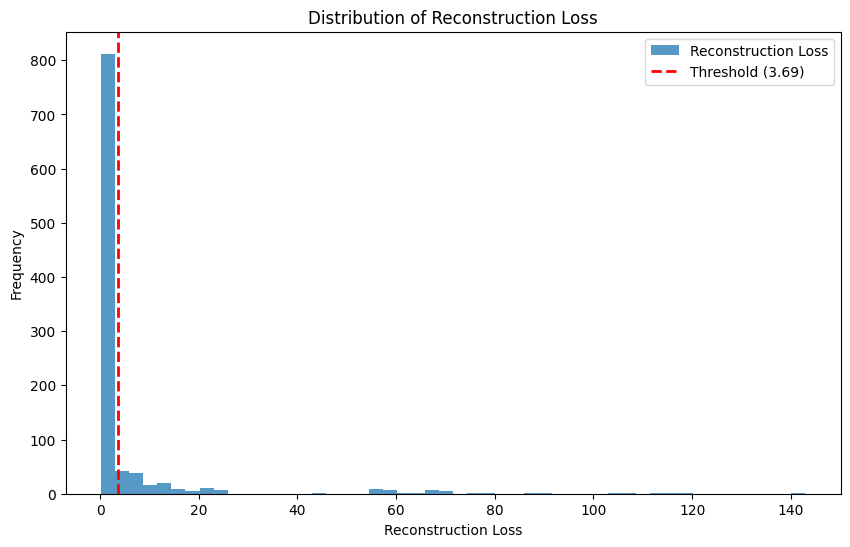

Threshold (Ngưỡng): 3.6918980455398542


In [9]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ của reconstruction_loss
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_loss, bins=50, alpha=0.75, label='Reconstruction Loss')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold:.2f})')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Loss')
plt.legend()
plt.show()


print(f"Threshold (Ngưỡng): {threshold}")